# Consumption-Saving Model

**Table of contents**<a id='toc0_'></a>    
- 1. [Interpolation](#toc1_)    
  - 1.1. [Example](#toc1_1_)    
- 2. [Setup model](#toc2_)    
- 3. [Solve - value function interation (vfi)](#toc3_)    
  - 3.1. [Value and consumption functions across periods](#toc3_1_)    
  - 3.2. [Initial period](#toc3_2_)    
  - 3.3. [MPC](#toc3_3_)    
- 4. [Simulate](#toc4_)    
  - 4.1. [Income](#toc4_1_)    
  - 4.2. [Asset distribution](#toc4_2_)    
  - 4.3. [Intertemporal MPCs](#toc4_3_)    
- 5. [Solve - endogenous grid method (egm)](#toc5_)    
  - 5.1. [Compare solution methods](#toc5_1_)    
  - 5.2. [MPC](#toc5_2_)    
  - 5.3. [Intertemporal MPCs](#toc5_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Content:** Solves and simulates a simple consumption-saving model.

**Solution methods:** *Value function iteration* (`vfi`) and the *endogenous grid-point method* (`egm`).

**Packages you should know:**

1. [quantecon](https://quantecon.org/)
2. [EconModel](https://github.com/NumEconCopenhagen/EconModel) ([notebooks](https://github.com/NumEconCopenhagen/EconModelNotebooks))
2. [consav](https://github.com/NumEconCopenhagen/ConsumptionSaving) ([notebooks](https://github.com/NumEconCopenhagen/ConsumptionSavingNotebooks))

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from ConSavModel import ConSavModelClass

## 1. <a id='toc1_'></a>[Interpolation](#toc0_)

To consider dynamic optimization problems, we will need to think about *interpolation*.

**Inputs:**

1. Sorted vector of known points (grid vector), $G = \{G_i\}_{i=0}^{n-1}$.
2. Vector of known values (at these points), $F = \{F_i = f(G_i)\}_{i=0}^{n-1}$.
3. A new point, `x`, not in $G$.

**Algorithm:** `linear_interpolate()`
1. Determine `i`  such that

$$
G_i \leq x < G_{i+1}
$$

2. Compute interpolated value by

$$
y =  F_{i} + \frac{F_{i+1}-F_{i}}{G_{i+1}-G_{i}}(x-G_{i})
$$

**Extrapolation:**

1. Below where $x < G_1$ use $i = 0$.

$$
y =  F_{0} + \frac{F_{1}-F_{0}}{G_{1}-G_{0}}(x-G_{0})
$$

2. Above where $x > G_{n-2}$ (use $i = n-2$)

$$
y =  F_{n-2} + \frac{F_{n-1}-F_{n-2}}{G_{n-1}-G_{n-2}}(x-G_{n-2})
$$

In [2]:
def linear_interpolate(G,F,x):
    """ linear interpolation (and extrapolation)
    
    Args:
    
        G (np.ndarray): known points
        F (np.ndarray): known values
        x (float): point to be interpolated
        
    Returns:
    
        y (float): intepolated value
    
    """
    
    assert len(G) == len(F)
    n = len(G)
    
    # a. find index in known points
    if x < G[1]: # exprapolation below
    
        i = 0
    
    elif x > G[-2]: # extrapolation above
        
        i = n-2

    else: # true interpolation
        
        # search
        i = 0 
        while x >= G[i+1] and i < n-1:
            i += 1
        
        # check
        assert x >= G[i]
        assert x < G[i+1]

    # b. interpolate
    diff_G = G[i+1]-G[i]
    diff_F = F[i+1]-F[i]
    slope = diff_F/diff_G
    y = F[i] + slope*(x-G[i])
    
    return y

### 1.1. <a id='toc1_1_'></a>[Example](#toc0_)

Consider the following function and known points:

In [3]:
f = lambda x: (x-3)**3 - 3*x**2 + 5*x

G = np.linspace(-5,10,6)
F = f(G)

True function values at fine grid:

In [4]:
grid = np.linspace(-6,11,500) # 500 makes it "fine"
F_true = f(grid)

Simple test:

x = -2.3 -> true = -176.2, interpolated = -193.5
x =  4.9 -> true =  -40.7, interpolated =  -33.3
x =  7.5 -> true =  -40.1, interpolated =  -24.5
x =  9.1 -> true =   24.1, interpolated =   50.7


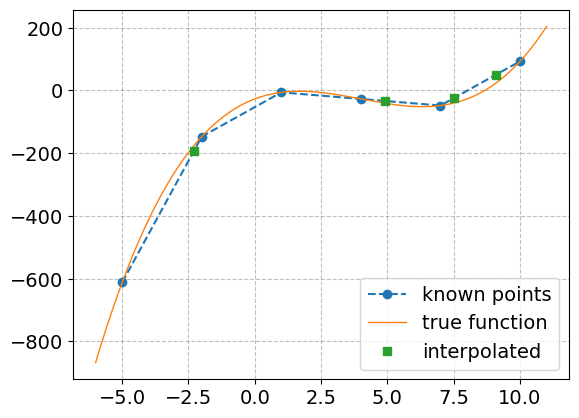

In [5]:
# interpolate
X = [-2.3,4.9,7.5,9.1]
F_approx = []
for x in X:
    true = f(x)
    y = linear_interpolate(G,F,x)
    F_approx.append(y)
    print(f'x = {x:4.1f} -> true = {true:6.1f}, interpolated = {y:6.1f}')

# plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(G,F,'--o',label='known points')
ax.plot(grid,F_true,'-',lw=1,label='true function')
ax.plot(X,F_approx,'s',lw=1,label='interpolated')
ax.legend(loc='lower right',facecolor='white',frameon=True)
fig.savefig('figs/linear_interpolation.pdf')   

**Consav:**

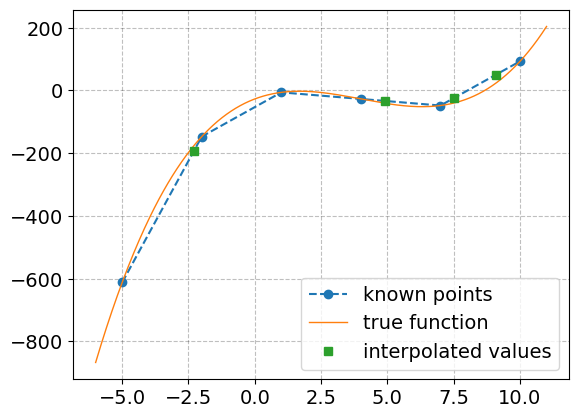

In [6]:
from consav.linear_interp import interp_1d

# b. interpolate
F_approx_consav = np.array([interp_1d(G,F,xi) for xi in X])

# c. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(G,F,'--o',label='known points')
ax.plot(grid,F_true,'-',lw=1,label='true function')
ax.plot(X,F_approx_consav,'s',lw=1,label='interpolated values')
ax.legend(loc='lower right',facecolor='white',frameon=True);

**Task:** Increase the number of *known* points in the cell below and see what happens.

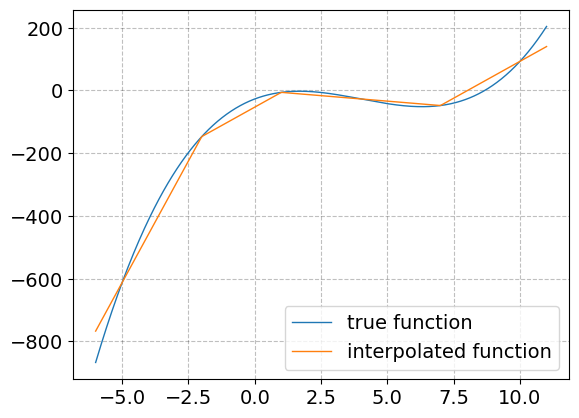

In [7]:
# a. known
G_ = np.linspace(-5,10,6)
#G_ = np.linspace(-5,10,200)
F_ = f(G_)

# b. interpolation
F_approx_consav = np.array([interp_1d(G_,F_,xi) for xi in grid])

# c. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(grid,F_true,'-',lw=1,label='true function')
ax.plot(grid,F_approx_consav,'-',lw=1,label='interpolated function')
ax.legend(loc='lower right',facecolor='white',frameon=True);

**Note:**

1. Linear interpolation works best when the function does not curve too much.
2. *Extrapolation* is much worse than *interpolation*.

**Multiple dimensions:** Same principle.

## 2. <a id='toc2_'></a>[Setup model](#toc0_)

In [8]:
model_vfi = ConSavModelClass()

**Question:** Which methods have been called now?

In [9]:
# unpack for easy access
par = model_vfi.par
sol = model_vfi.sol
sim = model_vfi.sim

**Grids:**

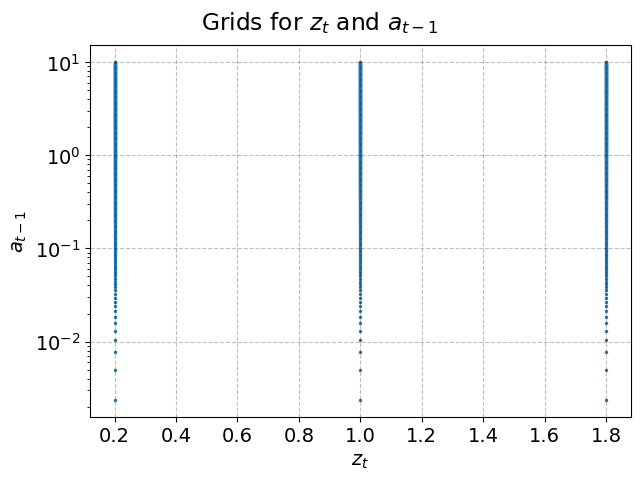

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

z_grid,a_grid = np.meshgrid(par.z_grid,par.a_grid,indexing='ij')
ax.scatter(z_grid,a_grid,2)

ax.set_yscale('log')
ax.set_xlabel('$z_t$')
ax.set_ylabel('$a_{t-1}$')

fig.suptitle('Grids for $z_t$ and $a_{t-1}$')
fig.tight_layout(pad=0.5)
fig.savefig('figs/grids.pdf')

**Transition matrix for $z_t$:**

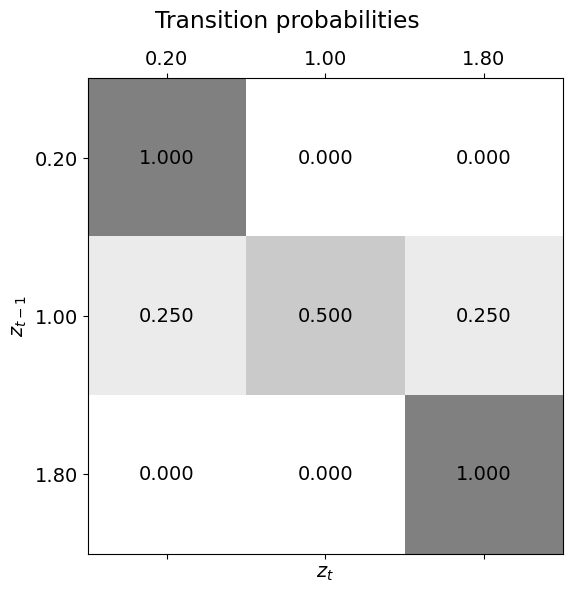

In [11]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.grid(False)
h = ax.matshow(par.z_trans,cmap='Greys',alpha=0.5)

for (i, j), value in np.ndenumerate(par.z_trans):
    ax.text(j, i, f'{value:0.3f}', ha='center', va='center')
    
z_labels = [f'{z:.2f}' for z in par.z_grid]
xaxis = np.arange(par.z_grid.size)
ax.set_xticks(xaxis)
ax.set_xticklabels(z_labels) 
ax.set_yticks(xaxis)
ax.set_yticklabels(z_labels) 

ax.set_xlabel('$z_{t}$')
ax.set_ylabel('$z_{t-1}$')

fig.suptitle('Transition probabilities')
fig.tight_layout(pad=0.75)
fig.savefig('figs/z_trans.pdf')

**Marginal CDFs:**

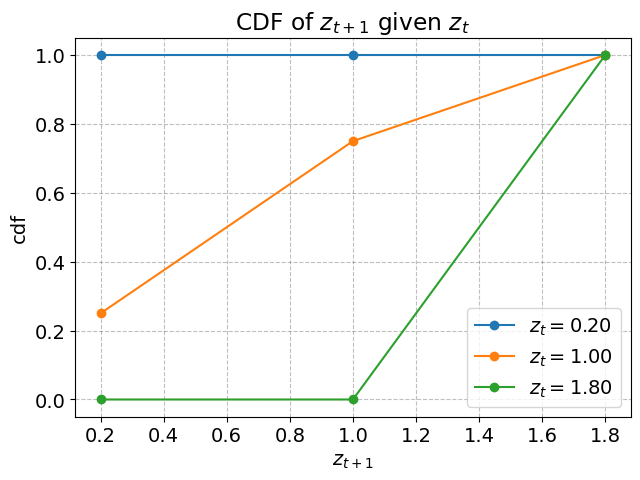

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('CDF of $z_{t+1}$ given $z_t$')
for i_z in range(par.Nz):
    ax.plot(par.z_grid,par.z_trans_cumsum[i_z],'-o',label=f'$z_t={par.z_grid[i_z]:.2f}$')
ax.set_xlabel('$z_{t+1}$')
ax.set_ylabel('cdf')
ax.legend()
fig.tight_layout(pad=0.5)

## 3. <a id='toc3_'></a>[Solve - value function interation (vfi)](#toc0_)

In [13]:
model_vfi.solve(do_print=True,algo='vfi')

period t =  2 solved in 0.0 secs  
period t =  1 solved in 9.3 secs  
period t =  0 solved in 0.0 secs  
model solved in 9.3 secs


### 3.1. <a id='toc3_1_'></a>[Value and consumption functions across periods](#toc0_)

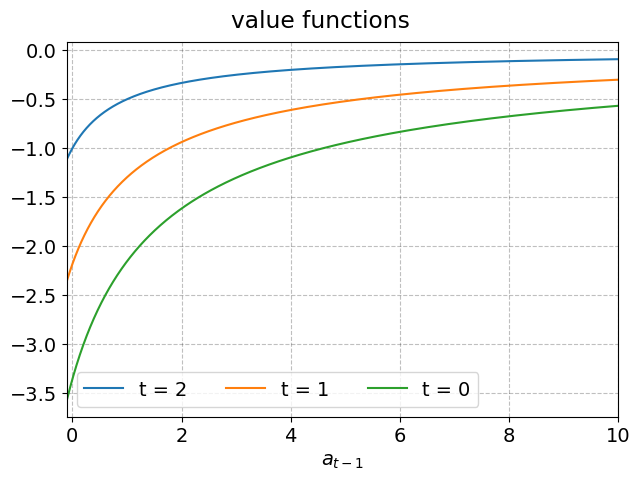

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for k in range(par.T):
    t = par.T-1-k
    ax.plot(par.a_grid,sol.v[t,1,:],label=f'{t = }')
    
ax.legend(frameon=True,ncol=3)
ax.set_xlabel('$a_{t-1}$')
ax.set_xlim([par.a_grid[0],par.a_grid[-1]])

fig.suptitle('value functions')
fig.tight_layout(pad=0.5)
fig.savefig('figs/v_funcs.pdf')

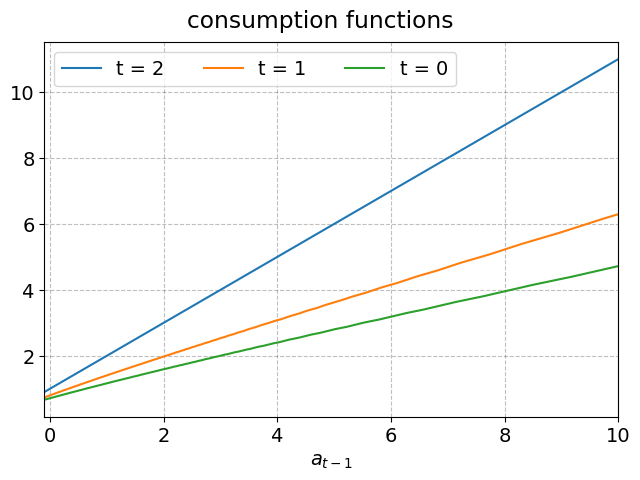

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for k in range(par.T):
    t = par.T-1-k
    ax.plot(par.a_grid,sol.c[t,1,:],label=f'{t = }')
    
ax.legend(frameon=True,ncol=3)
ax.set_xlabel('$a_{t-1}$')
ax.set_xlim([par.a_grid[0],par.a_grid[-1]])

fig.suptitle('consumption functions')
fig.tight_layout(pad=0.5)
fig.savefig('figs/c_funcs.pdf')

### 3.2. <a id='toc3_2_'></a>[Initial period](#toc0_)

**Low risk comparison model:**

In [16]:
model_vfi_low_risk = model_vfi.copy()
model_vfi_low_risk.par.Delta /= 2.0 # half the risk
model_vfi_low_risk.allocate() # recalculate grids
model_vfi_low_risk.solve(do_print=False,algo='vfi')

**Permanent income hypothethis behavior:**

In [17]:
PIH_fac = (par.beta*(1+par.r))**(1/par.sigma)*(1+par.r)**(-1)
PIH_MPC = (1-PIH_fac)/(1-PIH_fac**par.T)

s0 = (1+par.r)*par.a_grid
h0 = par.w + par.w/(1+par.r) + par.w/(1+par.r)**2

c_PIH = PIH_MPC*(s0+h0)
a_PIH = (1+par.r)*par.a_grid + par.w - c_PIH

**Consumption function:**

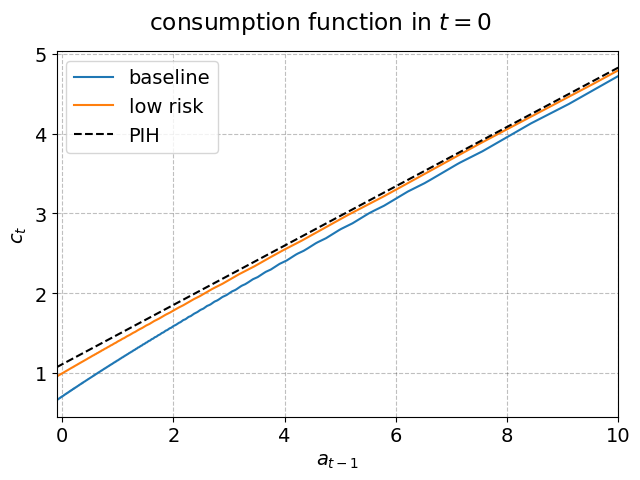

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(par.a_grid,sol.c[0,1,:],label='baseline')
ax.plot(par.a_grid,model_vfi_low_risk.sol.c[0,1,:],label='low risk')
ax.plot(par.a_grid,c_PIH,label='PIH',color='black',linestyle='--')

ax.legend(frameon=True)
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('$c_t$')
ax.set_xlim([par.a_grid[0],par.a_grid[-1]])

fig.suptitle('consumption function in $t=0$')
fig.tight_layout(pad=0.5)
fig.savefig('figs/c_func.pdf')

**Savings function:**

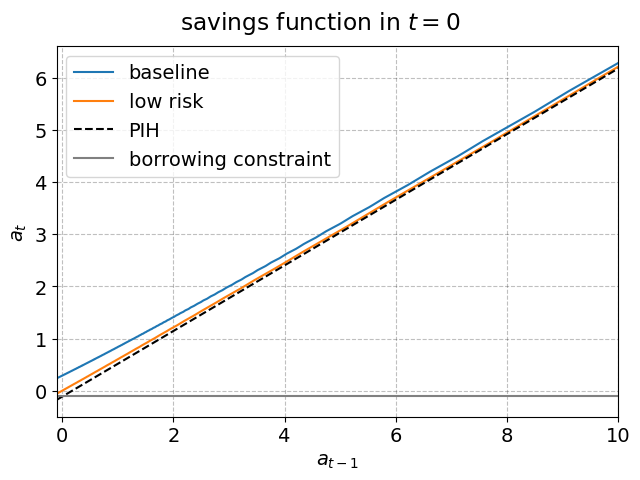

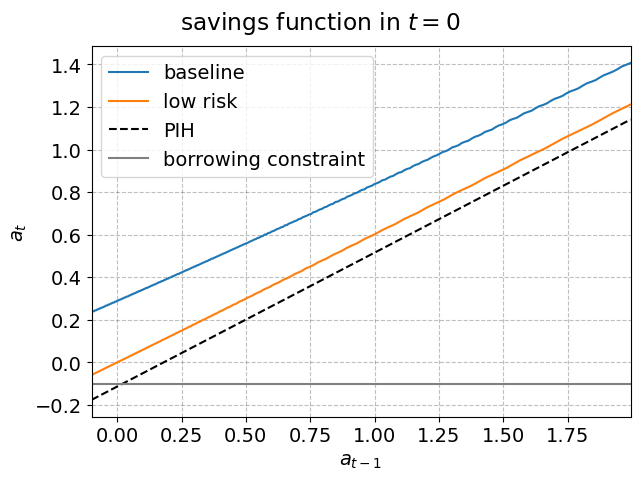

In [19]:
for a_max in [np.inf,2]:

    I = par.a_grid < a_max

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    ax.plot(par.a_grid[I],sol.a[0,1,I],label='baseline')
    ax.plot(par.a_grid[I],model_vfi_low_risk.sol.a[0,1,I],label='low risk')
    ax.plot(par.a_grid[I],a_PIH[I],label='PIH',color='black',linestyle='--')

    ax.axhline(par.a_min,color='grey',label='borrowing constraint')

    ax.legend(frameon=True)
    ax.set_xlabel('$a_{t-1}$')
    ax.set_ylabel('$a_t$') 
    ax.set_xlim([par.a_grid[0],par.a_grid[I][-1]])

    fig.suptitle('savings function in $t=0$')
    fig.tight_layout(pad=0.5)

    if np.isfinite(a_max):
        fig.savefig('figs/a_func.pdf')
    else:
        fig.savefig('figs/a_func_zoom.pdf')

    plt.show()

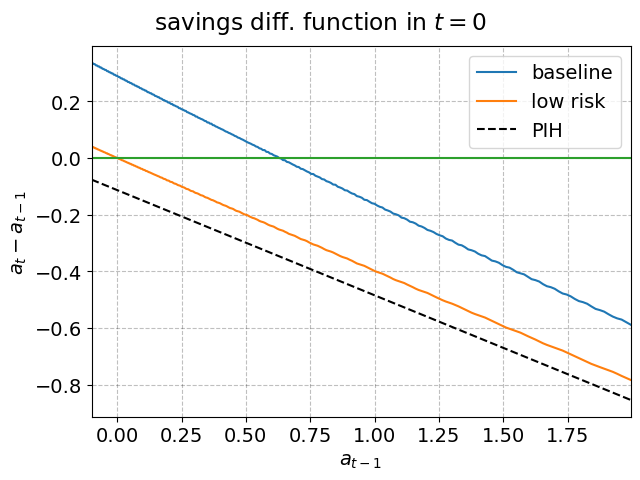

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

I = par.a_grid < 2

ax.plot(par.a_grid[I],sol.a[0,1,I]-par.a_grid[I],label=f'baseline')
ax.plot(par.a_grid[I],model_vfi_low_risk.sol.a[0,1,I]-par.a_grid[I],label=f'low risk')
ax.plot(par.a_grid[I],a_PIH[I]-par.a_grid[I],label='PIH',color='black',linestyle='--')

ax.plot(par.a_grid[I],np.zeros(I.sum()))

ax.legend(frameon=True)
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('$a_t-a_{t-1}$')
ax.set_xlim([par.a_grid[0],par.a_grid[I][-1]])

fig.suptitle('savings diff. function in $t=0$')
fig.tight_layout(pad=0.5)
fig.savefig('figs/a_diff_func.pdf')

### 3.3. <a id='toc3_3_'></a>[MPC](#toc0_)

In [21]:
def calc_MPC(model,chi,Na,algo='vfi'):

    par = model.par
    model_base = model.copy()
    model_alt = model.copy()

    for model_,val in [(model_base,0.0),(model_alt,chi)]:
        
        model_.par.chi[0] = val
        model_.par.Na = Na
        model_.allocate()
        model_.solve(do_print=False,algo=algo)

    MPC = (model_alt.sol.c[0,1,:]-model_base.sol.c[0,1,:])/chi

    return model_base.par.a_grid, MPC

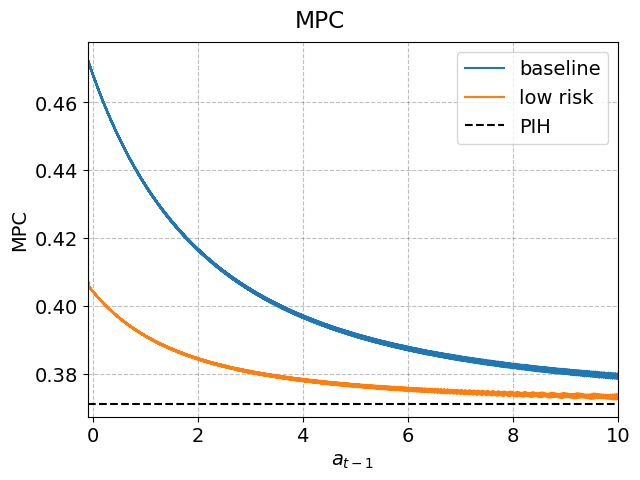

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

chi = 0.1
Na = 100_000
a_grid, MPC = calc_MPC(model_vfi,chi,Na,algo='vfi')
_, MPC_low_risk = calc_MPC(model_vfi_low_risk,chi,Na,algo='vfi')

ax.plot(a_grid,MPC,label='baseline')
ax.plot(a_grid,MPC_low_risk,label='low risk')
ax.axhline(PIH_MPC,color='black',linestyle='--',label='PIH')

ax.legend(frameon=True)
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('MPC')
ax.set_xlim([par.a_grid[0],par.a_grid[:][-1]])

fig.suptitle('MPC')
fig.tight_layout(pad=0.5)
fig.savefig('figs/MPC.pdf')

**Question:** What happens with lower `Na` or `chi`?

## 4. <a id='toc4_'></a>[Simulate](#toc0_)

In [23]:
model_vfi.prepare_simulate()

model prepared for simulation in 0.0 secs


In [24]:
model_vfi.simulate()

model simulated in 3.5 secs secs


### 4.1. <a id='toc4_1_'></a>[Income](#toc0_)

In [25]:
for t in range(par.T):

    for i_z in range(par.Nz):
        print(f'Pr[z = {par.z_grid[i_z]:.2f}] = {np.mean(sim.i_z[t,:] == i_z):.2f}')

    print(f'mean(w*z) = {np.mean(par.w*par.z_grid[sim.i_z[t]]):.2f}')
    print(f'var(w*z)  = {np.var(par.w*par.z_grid[sim.i_z[t]]):.2f}')

    if not t == par.T-1: print('')

Pr[z = 0.20] = 0.25
Pr[z = 1.00] = 0.50
Pr[z = 1.80] = 0.25
mean(w*z) = 1.00
var(w*z)  = 0.32

Pr[z = 0.20] = 0.37
Pr[z = 1.00] = 0.25
Pr[z = 1.80] = 0.38
mean(w*z) = 1.00
var(w*z)  = 0.48

Pr[z = 0.20] = 0.44
Pr[z = 1.00] = 0.12
Pr[z = 1.80] = 0.44
mean(w*z) = 1.00
var(w*z)  = 0.56


### 4.2. <a id='toc4_2_'></a>[Asset distribution](#toc0_)

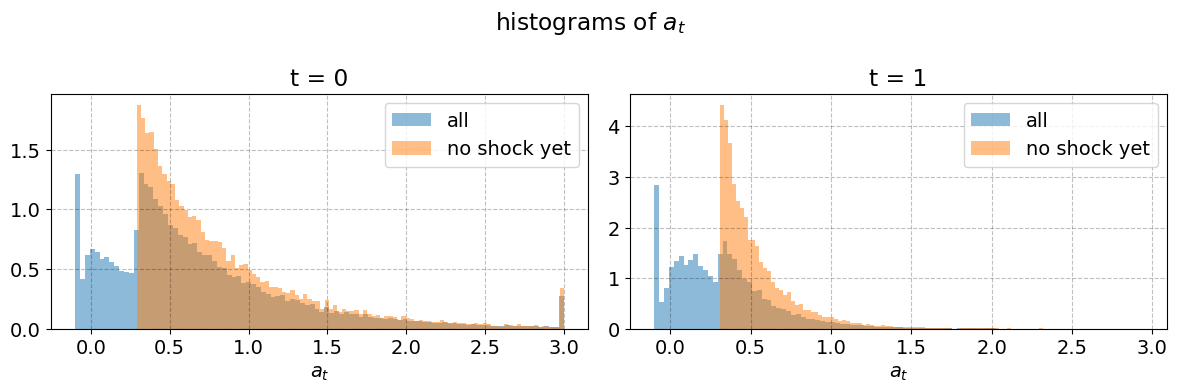

In [26]:
fig = plt.figure(figsize=(12,4))

for t in range(par.T-1):

    ax = fig.add_subplot(1,2,t+1)
    ax.set_title(f'{t = }')
    ax.hist(np.clip(sim.a[t],par.a_min,3.0),bins=100,density=True,label='all',alpha=0.5)
    
    I = sim.i_z[t] == 1
    ax.hist(np.clip(sim.a[t,I],par.a_min,3.0),bins=100,density=True,label='no shock yet',alpha=0.5)

    ax.set_xlabel('$a_{t}$')
    ax.legend(frameon=True)

fig.suptitle('histograms of $a_{t}$')
fig.tight_layout(pad=1.0)
fig.savefig('figs/a_hist.pdf')

### 4.3. <a id='toc4_3_'></a>[Intertemporal MPCs](#toc0_)

In [27]:
def calc_MPC_dyn(model,a_ini=0,chi=1e-4,t=0,algo='vfi'):

    model_base = model.copy()
    model_base.par.simN = 1
    model_base.allocate()
    model_base.sim.a_ini[0] = a_ini
    model_base.sim.p_z[:] = 0.5
    model_base.solve(do_print=False,algo=algo)
    model_base.simulate(do_print=False)

    model_alt = model_base.copy()
    model_alt.par.chi[t] = chi
    model_alt.solve(do_print=False,algo=algo)
    model_alt.simulate(do_print=False)

    MPC_dyn = (model_alt.sim.c[:]-model_base.sim.c[:])/chi

    return MPC_dyn,model_base.sim.a,model_alt.sim.a

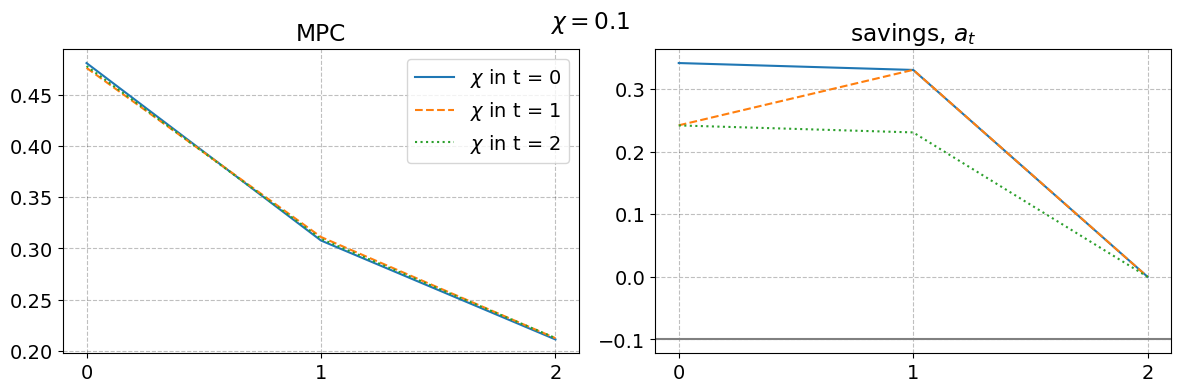

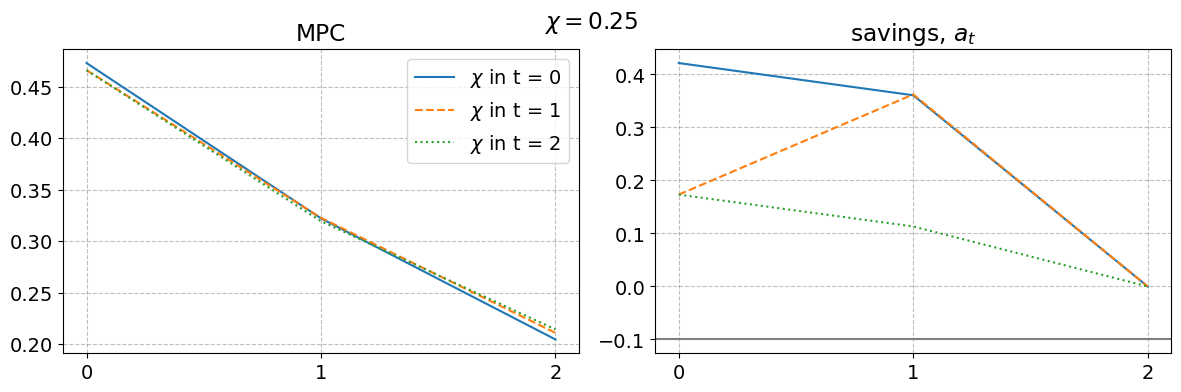

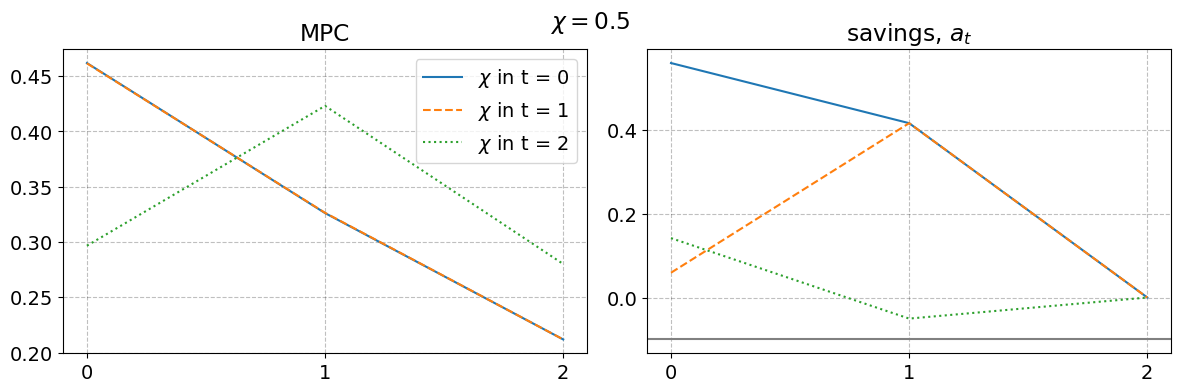

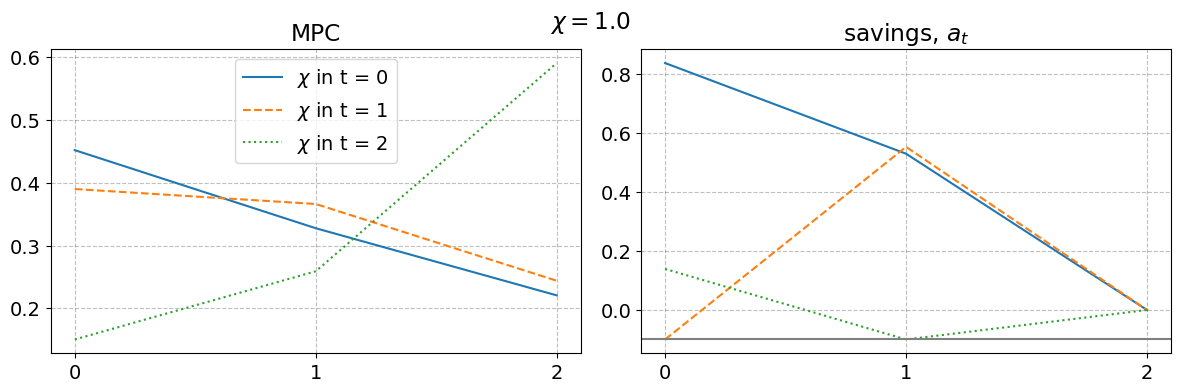

In [28]:
for i_chi,chi in enumerate([0.1,0.25,0.5,1.0]):

    fig = plt.figure(figsize=(12,4))

    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title('MPC')

    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title('savings, $a_t$')

    lss = ['-','--',':','-.']
    for t in range(par.T):

        MPC_dyn,a_base,a_alt = calc_MPC_dyn(model_vfi,a_ini=0.0,chi=chi,t=t)
        ax1.plot(MPC_dyn,ls=lss[t],label=f'$\\chi$ in {t = }')
        ax2.plot(a_alt,ls=lss[t])

    ax2.axhline(par.a_min,color='grey',label='borrowing constraint')
    ax1.legend(frameon=True)
    for ax in [ax1,ax2]:
        ax.set_xticks(np.arange(par.T));

    fig.tight_layout(pad=1.0)
    fig.suptitle(f'$\\chi = {chi}$')
    fig.savefig(f'figs/MPC_dyn_{i_chi}.pdf')

## 5. <a id='toc5_'></a>[Solve - endogenous grid method (egm)](#toc0_)

In [29]:
model_egm = model_vfi.copy()

In [30]:
model_egm.solve(do_print=True,algo='egm')

period t =  2 solved in 0.0 secs  
period t =  1 solved in 5.2 secs  
period t =  0 solved in 0.0 secs  
model solved in 5.2 secs


In [31]:
model_egm.solve(do_print=True,algo='egm')

period t =  2 solved in 0.0 secs  
period t =  1 solved in 0.0 secs  
period t =  0 solved in 0.0 secs  
model solved in 0.0 secs


### 5.1. <a id='toc5_1_'></a>[Compare solution methods](#toc0_)

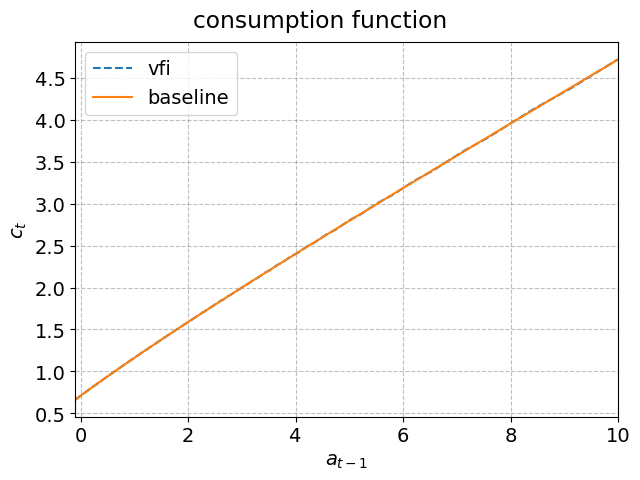

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(par.a_grid,model_vfi.sol.c[0,1,:],'--',label=f'vfi')
ax.plot(par.a_grid,model_egm.sol.c[0,1,:],label=f'baseline')

ax.legend(frameon=True)
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('$c_t$')
ax.set_xlim([par.a_grid[0],par.a_grid[-1]])

fig.suptitle('consumption function')
fig.tight_layout(pad=0.5)
fig.savefig('figs/c_func_vfi_vs_egm.pdf')

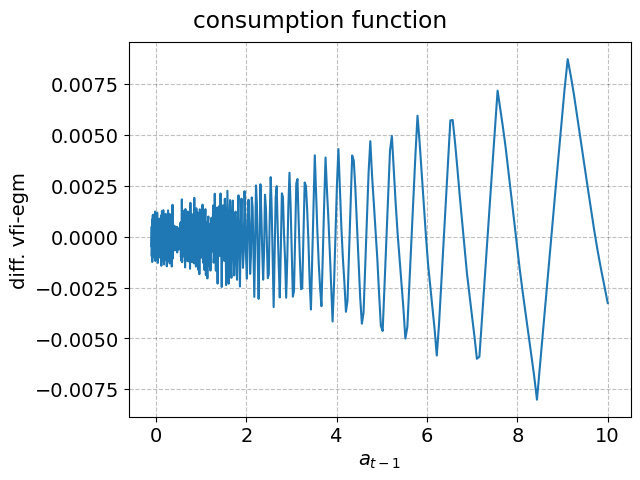

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(par.a_grid,model_vfi.sol.a[0,1,:]-model_egm.sol.a[0,1,:])
    
ax.set_xlabel('$a_{t-1}$');
ax.set_ylabel('diff. vfi-egm')

fig.suptitle('consumption function')
fig.tight_layout(pad=0.5)
fig.savefig('figs/c_func_vfi_vs_egm_diff.pdf')

### 5.2. <a id='toc5_2_'></a>[MPC](#toc0_)

**vfi vs egm:**

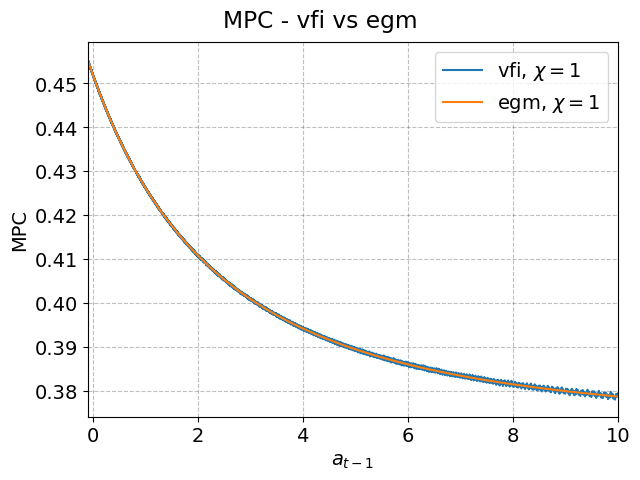

In [34]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

chi = 1.0
Na = 10_000
a_grid, MPC = calc_MPC(model_vfi,chi,Na,algo='vfi')
ax.plot(a_grid,MPC,label=f'vfi, $\\chi = 1$')

Na = par.Na # much fewer points needed for egm
a_grid, MPC = calc_MPC(model_egm,chi,Na,algo='egm')
ax.plot(a_grid,MPC,label=f'egm, $\\chi = 1$')

ax.legend(frameon=True)
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('MPC')
ax.set_xlim([par.a_grid[0],par.a_grid[:][-1]])

fig.suptitle('MPC - vfi vs egm')
fig.tight_layout(pad=0.5)
fig.savefig('figs/MPC_vfi_vs_egm.pdf')

**Does shock size matter?**

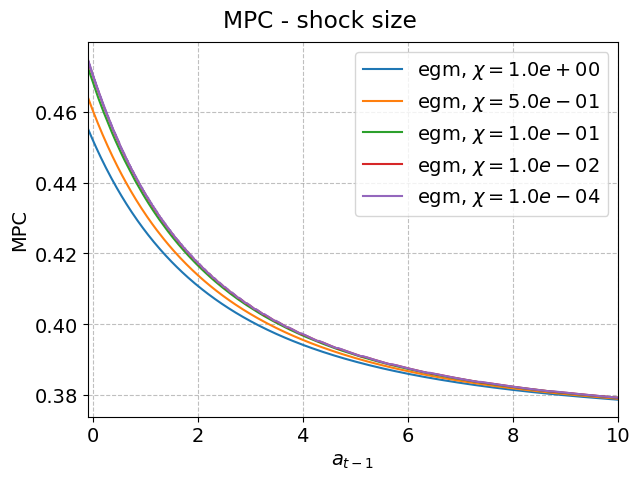

In [35]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for chi in [1.0,0.5,1e-1,1e-2,1e-4]:
    Na = par.Na
    a_grid, MPC = calc_MPC(model_egm,chi,Na,algo='egm')
    ax.plot(a_grid,MPC,label=f'egm, $\\{chi = :.1e}$')

ax.legend(frameon=True)
ax.set_xlabel('$a_{t-1}$')
ax.set_ylabel('MPC')
ax.set_xlim([par.a_grid[0],par.a_grid[:][-1]])

fig.suptitle('MPC - shock size')
fig.tight_layout(pad=0.5)
fig.savefig('figs/MPC_shock_size.pdf')

**Compare with slope of consumption function:**

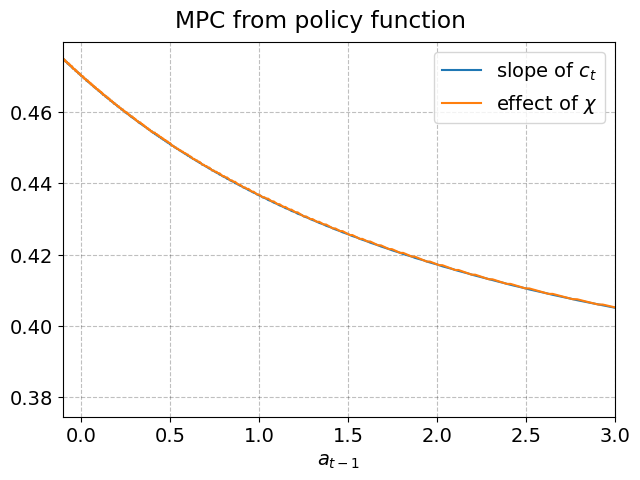

In [36]:
# calculate
c = model_egm.sol.c
MPC = (c[0,1,1:]-c[0,1,:-1])/((1+par.r)*(par.a_grid[1:]-par.a_grid[:-1]))

# plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(par.a_grid[:-1],MPC,label=f'slope of $c_t$')

chi = 1e-4
Na = par.Na
a_grid, MPC = calc_MPC(model_egm,chi,Na,algo='egm')
ax.plot(a_grid,MPC,label=f'effect of $\\chi$')

ax.set_xlim([par.a_min,3])
ax.set_xlabel('$a_{t-1}$')
ax.legend(frameon=True);

fig.suptitle('MPC from policy function')
fig.tight_layout(pad=0.5)

### 5.3. <a id='toc5_3_'></a>[Intertemporal MPCs](#toc0_)

In [37]:
fig.savefig('figs/c_func_vfi_vs_egm_diff.pdf')

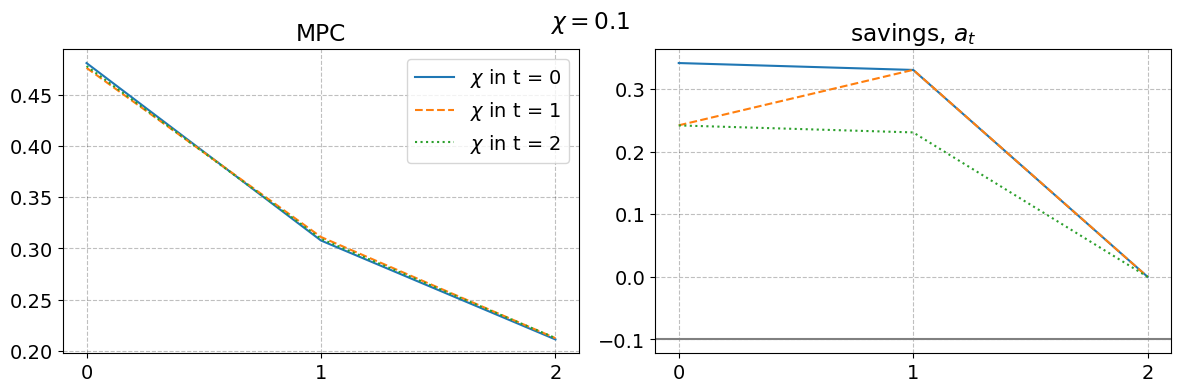

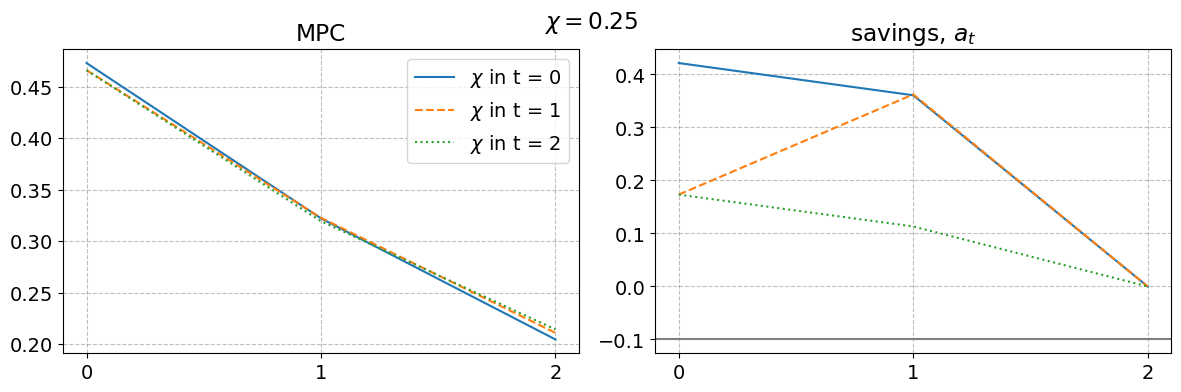

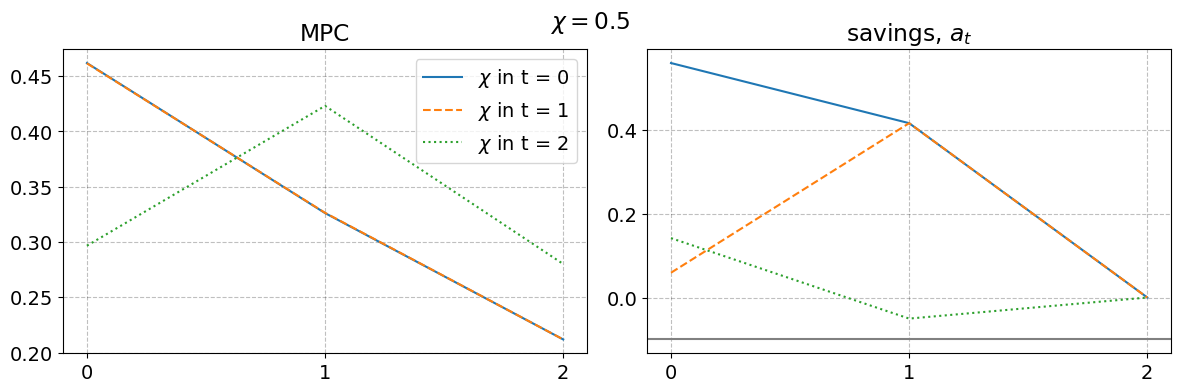

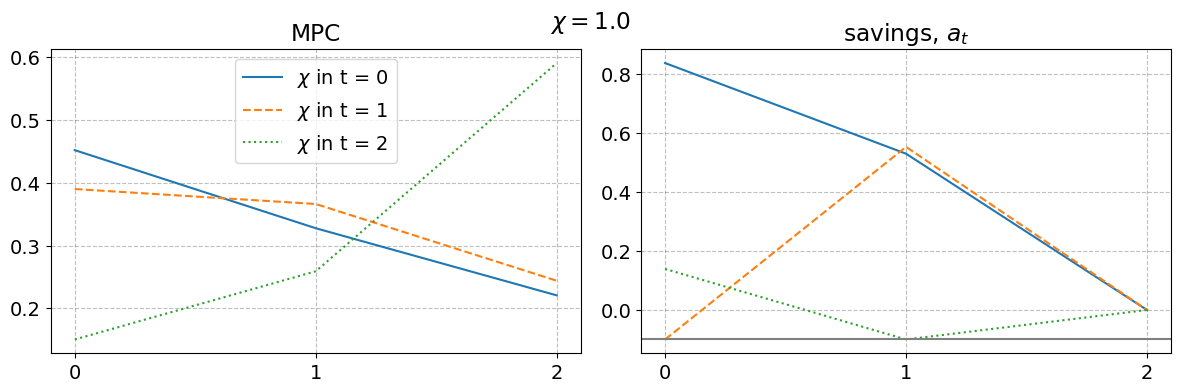

In [38]:
for i_chi,chi in enumerate([0.1,0.25,0.5,1.0]):

    fig = plt.figure(figsize=(12,4))

    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title('MPC')

    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title('savings, $a_t$')

    lss = ['-','--',':','-.']
    for t in range(par.T):

        MPC_dyn,a_base,a_alt = calc_MPC_dyn(model_egm,a_ini=0.0,chi=chi,t=t)
        ax1.plot(MPC_dyn,ls=lss[t],label=f'$\\chi$ in {t = }')
        ax2.plot(a_alt,ls=lss[t])

    ax2.axhline(par.a_min,color='grey',label='borrowing constraint')
    ax1.legend(frameon=True)
    for ax in [ax1,ax2]:
        ax.set_xticks(np.arange(par.T));

    fig.tight_layout(pad=1.0)
    fig.suptitle(f'$\\chi = {chi}$')
    fig.savefig(f'figs/MPC_dyn_{i_chi}_egm.pdf')